# Общие сведения о проекте
Строитстся модель машинного обучения для промышленной компании, разрабатывающая решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Получены данные о процессе очистки очистки золотоносной руды. Данные содержат информацию о содержании веществ в сырье, продукте и отвальных хвостах в процессе флотации, первого и второго этапа очистки, а также физические и расчетные характеристики и параметрические значения этапов очистки.  
**Задача: смоделировать процесс восстановления золота из золотосодержащей руды и спрогнозировать эффективность обогащения чернового и финального продукта на основании исходных данных**

# Подготовка данных

## Импорт библиотек, чтение датасетов и изучение данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [3]:
try:
    data_full = pd.read_csv(r'C:\Users\WinUser\Documents\Yandex\gold_recovery_full_new.csv')
    data_train = pd.read_csv(r'C:\Users\WinUser\Documents\Yandex\gold_recovery_train_new.csv')
    data_test = pd.read_csv(r'C:\Users\WinUser\Documents\Yandex\gold_recovery_test_new.csv')
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [4]:
#Приведём дату и время
data_full['date'] = pd.to_datetime(data_full['date'], format = '%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format = '%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format = '%Y-%m-%d %H:%M:%S')

## Проверка целевого признака в исходных данных

In [5]:
#Проверяем значения эффективности обогащения из таблицы, пересчитывая самостоятельно, согласно формулы.
my_rougher_output_recovery = 100 * (data_train['rougher.output.concentrate_au'] * \
                              (data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au'])) / \
(data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au']))

In [6]:
#Расчитаем среднее абсолютное отклонение между нашими расчетами и данными из датасета
mae = mean_absolute_error(data_train['rougher.output.recovery'], my_rougher_output_recovery) ** .5

In [7]:
print(f'Среднее абсолютное отклонение равно {mae}')

Среднее абсолютное отклонение равно 1.0550569266364691e-07


In [8]:
print(my_rougher_output_recovery.describe() - data_train['rougher.output.recovery'].describe())

count    0.000000e+00
mean     0.000000e+00
std      0.000000e+00
min     -0.000000e+00
25%     -1.421085e-14
50%     -2.842171e-14
75%      2.842171e-14
max      0.000000e+00
dtype: float64


**Эффективность обогащения вычислена корректно, MAE стремится к нулю**

## Оценка признаков в тестовой выборке

In [9]:
#Удалим данные, недоступные в тестовой выборке, из тренировочной выборки, за исключением целевых признаков. 
#И добавим в тестовую выборку целевые признаки из полной.
missing_test_data = \
data_train.drop(data_test.columns, axis = 1).columns.drop(['rougher.output.recovery', 'final.output.recovery'])
#missing_test_data
data_train = data_train.drop(missing_test_data, axis = 1)
data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')
data_train.shape, data_test.shape

((14149, 55), (5290, 55))

В тестовой выборке недоступны следующие данные: 
- финальные концентрации металлов в продукте и отвальных хвостах.
- концентрации металлов в продукте и отвальных хвостах после первичной очистки
- концентрации металлов в отвальных хвостах после вторичной очистки
- концентрации металлов в продукте и отвальных хвостах после флотации
- расчетные характеристики сырья на этапе флотации
- эффективности обогащения

## Предобработка данных

Заполняем пропуски средним значением между двумя "соседями" сверху и снизу, при организации датафрейма построчно с индексацией по времени подобный метод кажется наиболее логичным.

In [10]:
#data_train.duplicated().sum()
nan_list = data_train.isna().sum().sort_values()
nan_list = nan_list[nan_list > 0].index
data_train[nan_list] = data_train[nan_list].interpolate()

In [11]:
#data_test.duplicated().sum()
nan_list = data_test.isna().sum().sort_values()
nan_list = nan_list[nan_list > 0].index
data_test[nan_list] = data_test[nan_list].interpolate()

In [12]:
#Колечество пропусков равно нулю
data_train.isna().sum().sum(), data_test.isna().sum().sum()

(0, 0)

# Анализ данных

## Изменение концентрации металлов на различных этапах очистки

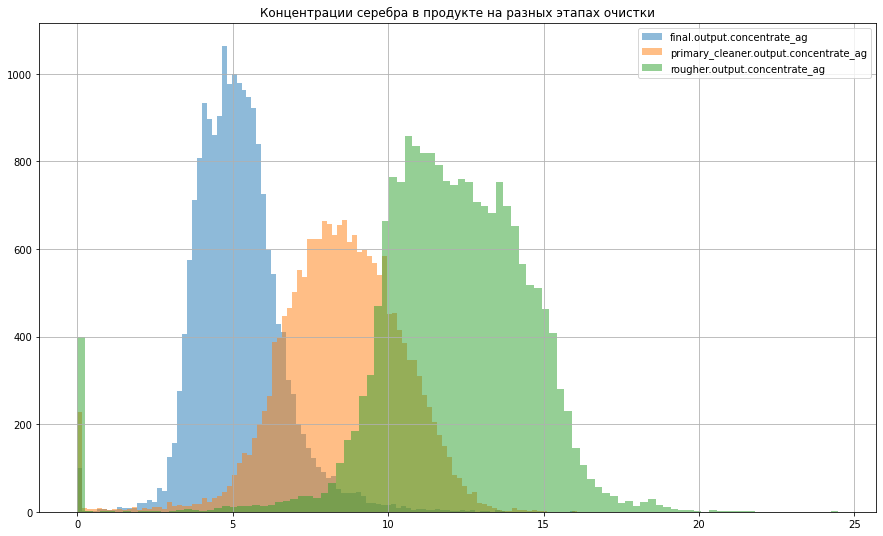

In [13]:
data_full['final.output.concentrate_ag'].hist(bins=100, alpha=.5, legend=True, figsize = (15,9))\
    .set_title('Концентрации серебра в продукте на разных этапах очистки')
data_full['primary_cleaner.output.concentrate_ag'].hist(bins=100, alpha=.5, legend=True)
data_full['rougher.output.concentrate_ag'].hist(bins=100, alpha=.5, legend=True);

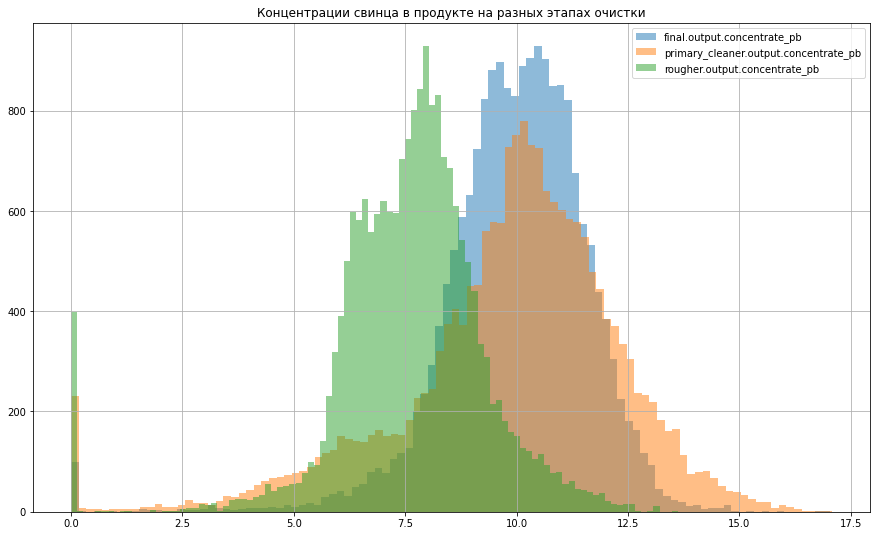

In [14]:
data_full['final.output.concentrate_pb'].hist(bins=100, alpha=.5, legend=True, figsize = (15,9))\
    .set_title('Концентрации свинца в продукте на разных этапах очистки')
data_full['primary_cleaner.output.concentrate_pb'].hist(bins=100, alpha=.5, legend=True)
data_full['rougher.output.concentrate_pb'].hist(bins=100, alpha=.5, legend=True);

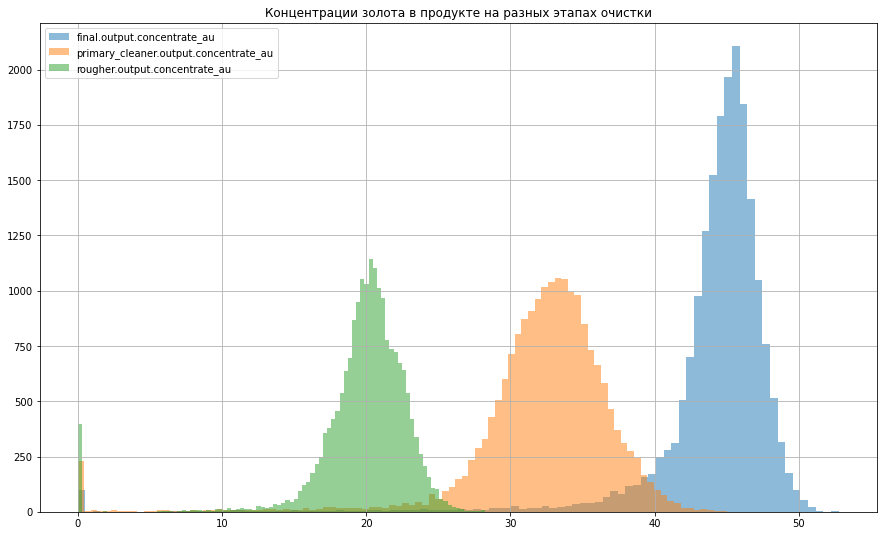

In [15]:
data_full['final.output.concentrate_au'].hist(bins=100, alpha=.5, legend=True, figsize = (15,9))\
    .set_title('Концентрации золота в продукте на разных этапах очистки')
data_full['primary_cleaner.output.concentrate_au'].hist(bins=100, alpha=.5, legend=True)
data_full['rougher.output.concentrate_au'].hist(bins=100, alpha=.5, legend=True);

- Концентрация золота в продукте, ожидаемо, возрастает более, чем в два раза
- Концентрация серебра в продукте снижается более, чем в два раза
- Концентрация свинца возрастает, приблизительно, на треть

## Распределение гранул сырья на обучающей и тестовой выборках

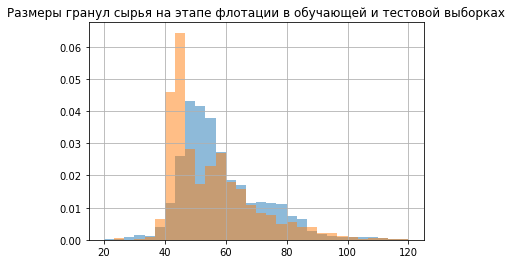

In [16]:
data_train['rougher.input.feed_size'].hist(bins = 30, alpha=.5, range=(20, 120), density = True)\
    .set_title('Размеры гранул сырья на этапе флотации в обучающей и тестовой выборках')
data_test['rougher.input.feed_size'].hist(bins = 30, alpha=.5, range=(20, 120), density=True);

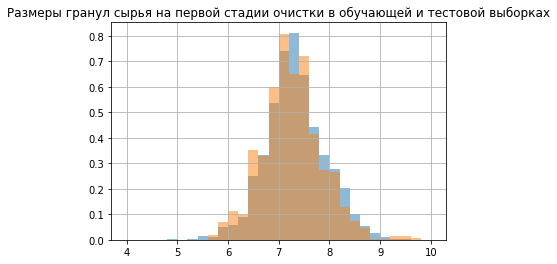

In [17]:
data_train['primary_cleaner.input.feed_size'].hist(bins=30, alpha=.5, range=(4, 10), density=True)\
    .set_title('Размеры гранул сырья на первой стадии очистки в обучающей и тестовой выборках')
data_test['primary_cleaner.input.feed_size'].hist(bins=30, alpha=.5, range=(4, 10), density=True);

**Размеры гранул сырья не сильно отличаются друг от друга, на оценку модели не будет оказано влияния**

## Исследование суммарной концентрации всех веществ на разных стадиях, поиск аномальных значений

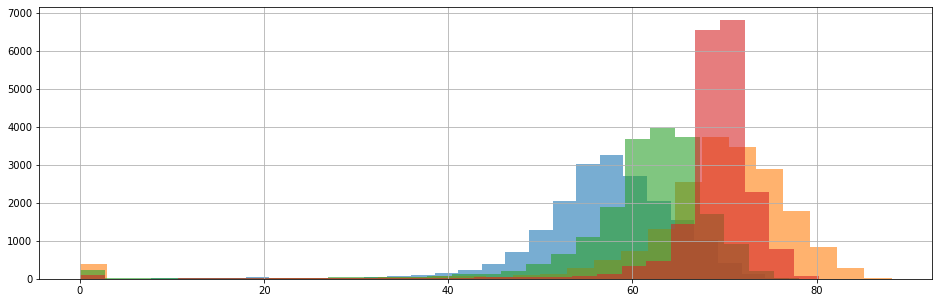

In [18]:
features_rougher_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]
features_rougher_output_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]
features_primary_output_concentrate = [
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol'
]
features_final_output_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol'
]
data_full[features_rougher_input_concentrate].sum(1).hist(bins = 30, figsize = (16,5), alpha=.6);
data_full[features_rougher_output_concentrate].sum(1).hist(bins = 30, alpha=.6);
data_full[features_primary_output_concentrate].sum(1).hist(bins = 30, alpha=.6);
data_full[features_final_output_concentrate].sum(1).hist(bins = 30, alpha=.6);

**Наблюдаются выбросы слева (нулевые значения), удалим строки с этими данными из тренировочного датасета**

In [19]:
data_zero_concentrates = data_full[(data_full[features_rougher_output_concentrate].sum(1) == 0) | \
                                   (data_full[features_primary_output_concentrate].sum(1) == 0) | \
                                   (data_full[features_final_output_concentrate].sum(1) == 0)]

In [20]:
#Удалим нулевые значения из тренировочной и тестовой выборки
data_train = data_train[~data_train.date.isin(data_zero_concentrates.date)]
data_test = data_test[~data_test.date.isin(data_zero_concentrates.date)]

**Данные готовы, переходим к построению модели**

# Построение модели

## Функция для вычисления итогового симметричного среднего абсолбтного процентного отклонения

In [21]:
def sMAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

## Обучение моделей и проверка качества кросс-валидацией. Выбор лучшей модели

In [22]:
#Подготовим тренировочную и валидационную выборки
features_train = data_train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1).reset_index(drop=True)
target_train = data_train[['final.output.recovery', 'rougher.output.recovery']].reset_index(drop=True)
features_train.shape, target_train.shape

((13725, 52), (13725, 2))

In [23]:
#Подготовим тестовую выборку
features_test = data_test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1).reset_index(drop=True)
target_test = data_test[['final.output.recovery', 'rougher.output.recovery']].reset_index(drop=True)
features_test.shape, target_test.shape

((5123, 52), (5123, 2))

In [33]:
model = LinearRegression()
scorer = make_scorer(sMAPE, greater_is_better=False)
scores = cross_val_score(model, features_train, target_train['rougher.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели линейной регрессии для чернового концентрата равна {abs(final_score):.2f}')

sMAPE модели линейной регрессии для чернового концентрата равна 7.23


In [34]:
model = LinearRegression()
scores = cross_val_score(model, features_train, target_train['final.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели линейной регрессии для финального концентрата равна {abs(final_score):.2f}')

sMAPE модели линейной регрессии для финального концентрата равна 10.97


In [35]:
#%%time
#final_score = -1000
#best_depth = 0
#for depth in range(1, 20):
#    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
#    scorer = make_scorer(sMAPE, greater_is_better=False)
#    scores = cross_val_score(model, features_train, target_train['rougher.output.recovery'], scoring=scorer, cv=5)
#    result = sum(scores)/ len(scores)
#    if result > final_score:
#        final_score = result
#        best_depth = depth
#best_depth, final_score
model = DecisionTreeRegressor(random_state=12345, max_depth=3)
scores = cross_val_score(model, features_train, target_train['rougher.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели решающего дерева для чернового концентрата равна {abs(final_score):.2f}')

sMAPE модели решающего дерева для чернового концентрата равна 7.25


In [36]:
#%%time
#final_score = -1000
#best_depth = 0
#for depth in range(1, 20):
#    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
#    scorer = make_scorer(sMAPE, greater_is_better=False)
#    scores = cross_val_score(model, features_train, target_train['final.output.recovery'], scoring=scorer, cv=5)
#    result = sum(scores)/ len(scores)
#    if result > final_score:
#        final_score = result
#        best_depth = depth
#best_depth, final_score
model = DecisionTreeRegressor(random_state=12345, max_depth=2)
scores = cross_val_score(model, features_train, target_train['final.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели решающего дерева для финального концентрата равна {abs(final_score):.2f}')

sMAPE модели решающего дерева для финального концентрата равна 9.55


In [38]:

#%%time
#final_score = -1000
#best_depth = 0
#best_est = 0
#for est in [10, 50, 100, 150]:
#    for depth in range(1, 10):
#        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
#        scorer = make_scorer(sMAPE, greater_is_better=False)
#        scores = cross_val_score(model, features_train, target_train['rougher.output.recovery'], scoring=scorer, cv=5)
#        result = sum(scores)/ len(scores)
#        if result > final_score:
#            final_score = result
#            best_depth = depth
#            best_est = est
#final_score, best_depth, best_est
model = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=3)
scores = cross_val_score(model, features_train, target_train['rougher.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели случайного леса для чернового концентрата равна {abs(final_score):.2f}')

sMAPE модели случайного леса для чернового концентрата равна 6.60


In [37]:
#%%time
#final_score = -1000
#best_depth = 0
#best_est = 0
#for est in [20, 30, 40]:
#    for depth in range(4, 7):
#        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
#        scorer = make_scorer(sMAPE, greater_is_better=False)
#        scores = cross_val_score(model, features_train, target_train['final.output.recovery'], scoring=scorer, cv=5)
#        result = sum(scores)/ len(scores)
#        if result > final_score:
#            final_score = result
#            best_depth = depth
#            best_est = est
#final_score, best_depth, best_est
model = RandomForestRegressor(random_state=12345, n_estimators=40, max_depth=4)
scores = cross_val_score(model, features_train, target_train['final.output.recovery'], scoring=scorer, cv=5)
#print(scores)
final_score = sum(scores)/ len(scores)
print(f'sMAPE модели случайного леса для финального концентрата равна {abs(final_score):.2f}')

sMAPE модели случайного леса для финального концентрата равна 9.00


## Проверка модели  на тестовых данных

In [42]:
model = RandomForestRegressor(random_state=12345, n_estimators = 100, max_depth=3)
model.fit(features_train, target_train['rougher.output.recovery'])
predictions = model.predict(features_test)
smape_rougher = sMAPE(target_test['rougher.output.recovery'], predictions)

In [43]:
model = RandomForestRegressor(random_state=12345, n_estimators = 100, max_depth=3)
model.fit(features_train, target_train['final.output.recovery'])
predictions = model.predict(features_test)
smape_final = sMAPE(target_test['final.output.recovery'], predictions)

In [45]:
final_smape = .025 * smape_rougher + .75 * smape_final
print(f'Итоговое sMAPE равно {abs(final_smape):.2f}')

Итоговое sMAPE равно 6.09


**Нами были получены данные о процессе восстановления золота из золотосодержащей руды. В ходе исследования был смоделирован весь процесс и проверен на тестовых данных.**
**Самая качественная модель - решающий лес, модель обучена и протестирована**